1.Encolsing cycle

We can set the radius and the coordinates as the variables, the total area $\pi r^2$ as the objective we are trying to minimize. But instead of optimizing $\pi r^2$, we will just optimize r instead which will also give us the optimal result.

For the constraint, we will restrict the distance from every points to the center to be less than or equal to the radius.

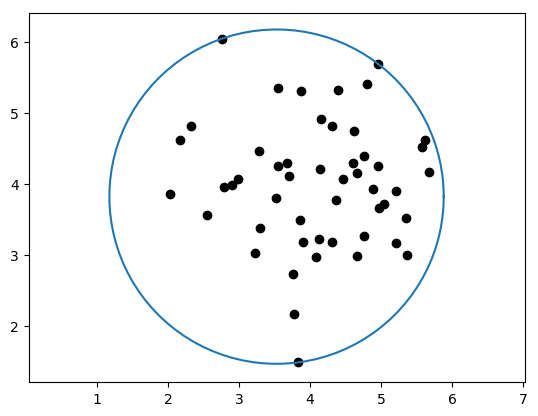

The coordinates of center are:[3.5272, 3.81821]
The radius is:2.3565575319186567


In [80]:
using JuMP, PyPlot, Mosek
x = 4 + randn(2,50)

m = Model(solver=MosekSolver(LOG=0))

@variable(m, r >= 0)
@variable(m, c[1:2])

@constraint(m, cstr[i in 1:50], norm(x[:,i] - c) <= r)

@objective(m, Min, r)

status = solve(m)

center = getvalue(c)
radius = getobjectivevalue(m)

t = linspace(0,2pi,100)

plot( center[1] + radius*cos.(t), center[2] + radius*sin.(t))
scatter( x[1,:], x[2,:], color="black")
axis("equal")
println("The coordinates of center are:", center)
println("The radius is:", radius)

2.The Huber loss

(a).

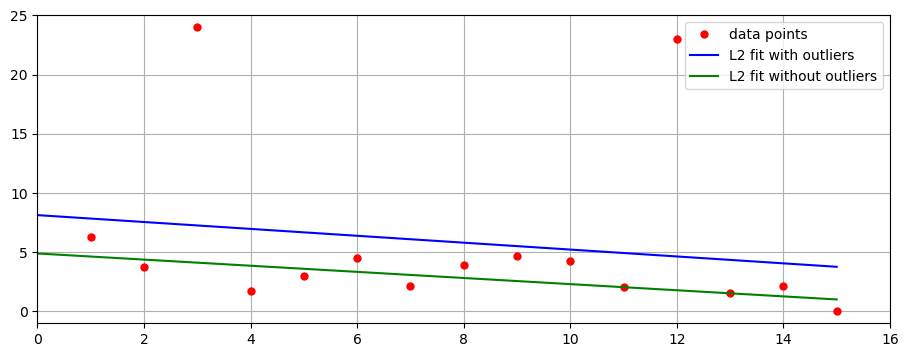

In [81]:
using PyPlot, Mosek

# data containing outliers
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11,
     3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

m = Model(solver=MosekSolver(LOG=0))
# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
@variable(m, u[1:k+1])

@objective(m, Min, sum( (y - A*u).^2 ) )

status = solve(m)
uopt = getvalue(u)

npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt

# data without outliers
x1 = [1,2,4,5,6,7,8,9,10,11,13,14,15]
y1 = [6.31, 3.78, 1.71, 2.99, 4.53, 2.11,
      3.88, 4.67, 4.25, 2.06, 1.58, 2.17, 0.02]

m = Model(solver=MosekSolver(LOG=0))
# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x1)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
@variable(m, u[1:k+1])

@objective(m, Min, sum( (y1 - A*u).^2 ) )

status = solve(m)
uopt1 = getvalue(u)
npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine1 = ffine * uopt1


figure(figsize=(11,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
plot(xfine, yfine1, "g-")
axis([0,16,-1,25])
legend(["data points", "L2 fit with outliers", "L2 fit without outliers"], loc="upper right")
grid()

As can be seen from the plot above, when fitting with outliers, the fit will be dragged towards the outliers.

(b).

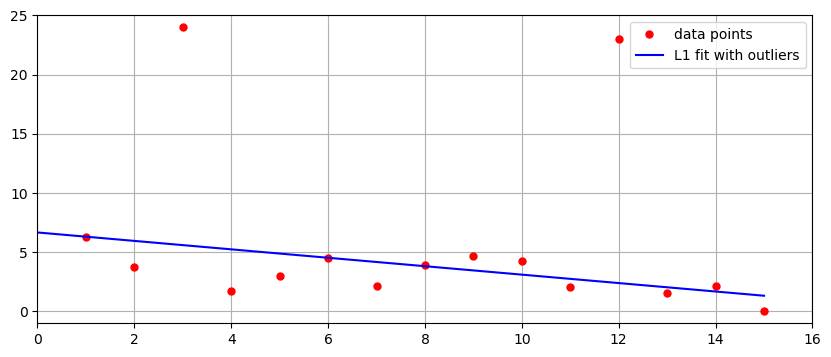

In [82]:
using JuMP, PyPlot, Mosek

# data containing outliers
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11,
    3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

m = Model(solver=MosekSolver(LOG=0))

# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
@variable(m, u[1:k+1])
@variable(m, t[1:15])

@constraint(m, t .>= y-A*u)
@constraint(m, t.>= -y+A*u)

@objective(m, Min, sum(t))

status = solve(m)

uopt = getvalue(u)

npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt

figure(figsize=(10,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,16,-1,25])
legend(["data points", "L1 fit with outliers"], loc="upper right")
grid()

As can be seen from the plot above, L1 cost fits the data pretty well. L2 cost is much more sensitive to outliers because L2 cost is the average of the data; whereas L1 norm is the median of the data, outliers don't take effect in it. Therefore L2 will be draged towards the outliers.

(c).

Reproduce the plot:

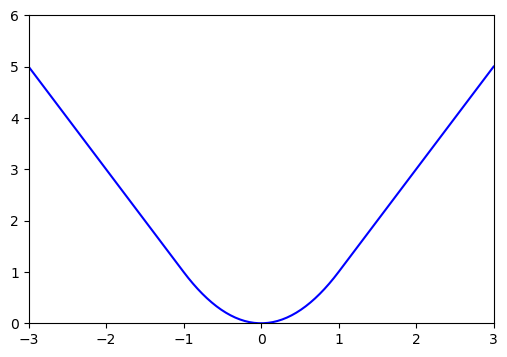

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1239abfd0>

In [83]:
using JuMP, Mosek, PyPlot

M = 1

x = linspace(-3,3,100)
y = []
for i in x
    m = Model(solver=MosekSolver(LOG=0))
    @variable(m, w <= M)
    @variable(m, v >= 0)

    @constraint(m, w+v >= abs(i))

    @objective(m, Min, w^2+2*M*v)

    solve(m)
    push!(y,getvalue(w)^2 + 2*M*getvalue(v))
end

figure(figsize=(6,4))
axis([-3,3,0,6])
plot(x, y, "b-")

Using Huber loss to fit the previous data:

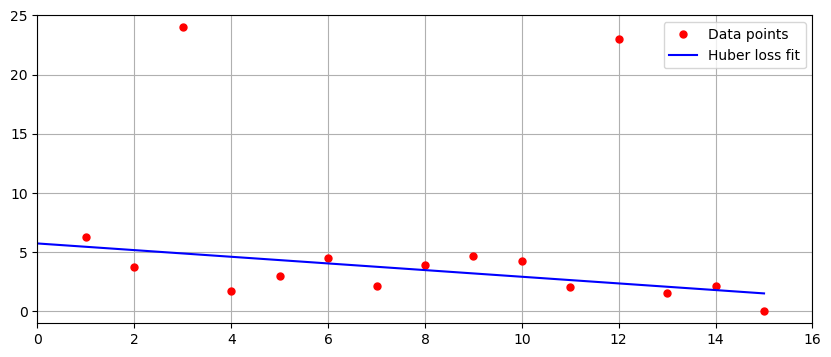

In [84]:
using JuMP, Mosek, PyPlot

# data containing outliers
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11,3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

m = Model(solver=MosekSolver(LOG=0))

# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

M = 1

@variable(m, w[1:15] <= M)
@variable(m, v[1:15] >= 0)
@variable(m, u[1:k+1])
@variable(m, t[1:15])
@constraint(m, [i in 1:15], t[i] >= y[i]-A[i,:]'*u)
@constraint(m, [i in 1:15], t[i] >= -y[i]+A[i,:]'*u)

for i = 1:15
    @constraint(m, w[i] + v[i] >= t[i])
end

@objective(m, Min, sum(w.^2+2*M*v))

status = solve(m)

uopt = getvalue(u)

npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt

figure(figsize=(10,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,16,-1,25])
legend(["Data points", "Huber loss fit"])
grid()

3.Heat pipe design
(a).
The geometric program is:


\begin{equation*}
\begin{aligned}
& \underset{T, r, w}{\text{minimize}}
& & \frac{1}{\alpha_4 T r^2} \\
& \text{subject to}
& & \frac{\alpha_1 T r}{w C_{max}} + \frac{\alpha_2 r}{C_{max}} + \frac{\alpha_3 r w}{C_{max}} \leq 1 \\
&&& \frac{T_{min}}{T} \leq 1 \\
&&& \frac{T}{T_{max}} \leq 1 \\
&&& \frac{r_{min}}{r} \leq 1 \\
&&& \frac{r}{r_{max}} \leq 1 \\
&&& \frac{w_{min}}{w} \leq 1 \\
&&& \frac{w}{w_{max}} \leq 1 \\
&&& \frac{10w}{r} \leq 1
\end{aligned}
\end{equation*}


let $x = \log T$, $y = \log r$, $z = \log w$

The problem converts to a convex optimization problem:


\begin{equation*}
\begin{aligned}
& \underset{x, y, z}{\text{minimize}}
& & -x -2y \\
& \text{subject to}
& & \log ({e^{\log {(\frac{\alpha_1}{C_{max}}})-z+x+y} + e^{\log {(\frac{\alpha_2}{C_{max}}})+y}} + e^{\log{(\frac{\alpha_3}{C_{max}})+y+z}}) \leq 0\\
&&& \log T_{min} \leq x \leq \log T_{max}\\
&&& \log r_{min} \leq y \leq \log r_{max}\\
&&& \log w_{min} \leq z \leq \log w_{max}\\
&&& y-z \geq \log 10
\end{aligned}
\end{equation*}


(b).

Sovling this convex optimization problem:

In [85]:
using JuMP, Mosek

m = Model(solver=MosekSolver(LOG=0))

@variable(m, x)
@variable(m, y)
@variable(m, z)

@NLconstraint(m, log(exp(log(1/500) -z + x +y) + exp(log(1/500) + y) + 
                 exp(log(1/500) + y + z)) <= 0)
@NLconstraint(m, y-z >= log(10))

@objective(m, Min, -x-2y)

status = solve(m)

println("Optimal T: ", exp(getvalue(x)))
println("Optimal r: ", exp(getvalue(y)))
println("Optimal w: ", exp(getvalue(z)))
println("The optimal value for this model is: ",getobjectivevalue(m))

Optimal T: 23.840213388232158
Optimal r: 46.39045139075652
Optimal w: 4.63904023429669
The optimal value for this model is: -10.845561091130621
